In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

from sklearn.model_selection import train_test_split

import scipy.stats as stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error


import os
from matplotlib import font_manager as fm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

## Modeling citation count with the Poisson distribution

In [12]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 


Read in data and add dummies for Dominant_Topic_small.

In [14]:
df = pd.read_csv("features.csv")

df = df[~df.Citations.str.contains('Data')]
df.Accesses = df.Accesses.str.replace('k','000',regex=True)

df.Citations = df.Citations.astype('int64')
df.Accesses = df.Accesses.astype('int64')
df = df.drop(['Document_No'],1)

dummies = pd.get_dummies(df.Dominant_Topic_small)
df = pd.concat([df,dummies],1)

Keep positive coef features.

In [15]:
y = df.Citations
X = df.drop(['Accesses','Citations','lenTitle','pubYear','pubMonth','Dominant_Topic_large','Topic_Perc_Contrib_large','avg_TPC_large','norm_contrib_large','Topic_Perc_Contrib_small','Counts_small','norm_contrib_small','delta_Months_small',2.0,0.0],1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1770 entries, 0 to 1773
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NumAuthors            1770 non-null   int64  
 1   ImpactFactor          1770 non-null   float64
 2   NatureAC              1770 non-null   int64  
 3   Counts_large          1770 non-null   int64  
 4   delta_Months_large    1770 non-null   int64  
 5   delta_AvgTPC_large    1770 non-null   float64
 6   Dominant_Topic_small  1770 non-null   float64
 7   avg_TPC_small         1770 non-null   float64
 8   delta_AvgTPC_small    1770 non-null   float64
 9   1.0                   1770 non-null   uint8  
 10  3.0                   1770 non-null   uint8  
 11  4.0                   1770 non-null   uint8  
dtypes: float64(5), int64(4), uint8(3)
memory usage: 143.5 KB


Train/test split and scale features.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [17]:
std = StandardScaler()
std.fit(X_train.values)

X_tr = std.transform(X_train)
X_te = std.transform(X_test)

Fit model to Poisson distribution.

In [48]:
model = sm.GLM(y_train, X_tr, family=sm.families.Poisson())
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Citations   No. Observations:                 1416
Model:                            GLM   Df Residuals:                     1404
Model Family:                 Poisson   Df Model:                           11
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -44609.
Date:                Fri, 17 Jul 2020   Deviance:                       83599.
Time:                        08:51:27   Pearson chi2:                 6.01e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1423      0.003     47.513      0.000       0.136       0.148
x2             1.1399      0.004    323.130      0.000       1.133       1.147
x3             0.0247      0.012      2.002      0.045       0.001       0.049
x4             0.4611      0.012     38.524      0.000       0.438       0.485
x5             0.0050      0.013      0.378      0.705      -0.021       0.031
x6             0.2808      0.011     25.505      0.000       0.259       0.302
x7             0.1219      0.043      2.852      0.004       0.038       0.206
x8             0.0134      0.015      0.909      0.363      -0.016       0.042
x9             0.2620      0.011     24.779      0.000       0.241       0.283
x10            0.4122      0.016     26.085      0.000       0.381       0.443
x11            0.2945      0.031      9.502      0.000       0.234       0.355
x12            0.5386      0.041     12.981      0.000       0.457       0.620
==============================================================================
"""

In [53]:
Coef = fit.params.reset_index(drop=True)
Feature = pd.Series(X.columns).astype(str).reset_index(drop=True)
top_coeffs = pd.concat([Feature, Coef],1)
top_coeffs.columns = (['Feature','Coef'])
top_coeffs = top_coeffs.sort_values(by=['Coef'],ascending=False).reset_index(drop=True)
topcoeffs = top_coeffs.head(9)
topcoeffs

,Feature,Coef
0,ImpactFactor,1.139872
1,4.0,0.538597
2,Counts_large,0.461066
3,1.0,0.412202
4,3.0,0.294487
5,delta_AvgTPC_large,0.280791
6,delta_AvgTPC_small,0.262021
7,NumAuthors,0.142350
8,Dominant_Topic_small,0.121903


Visualize beta coefficient values for features.

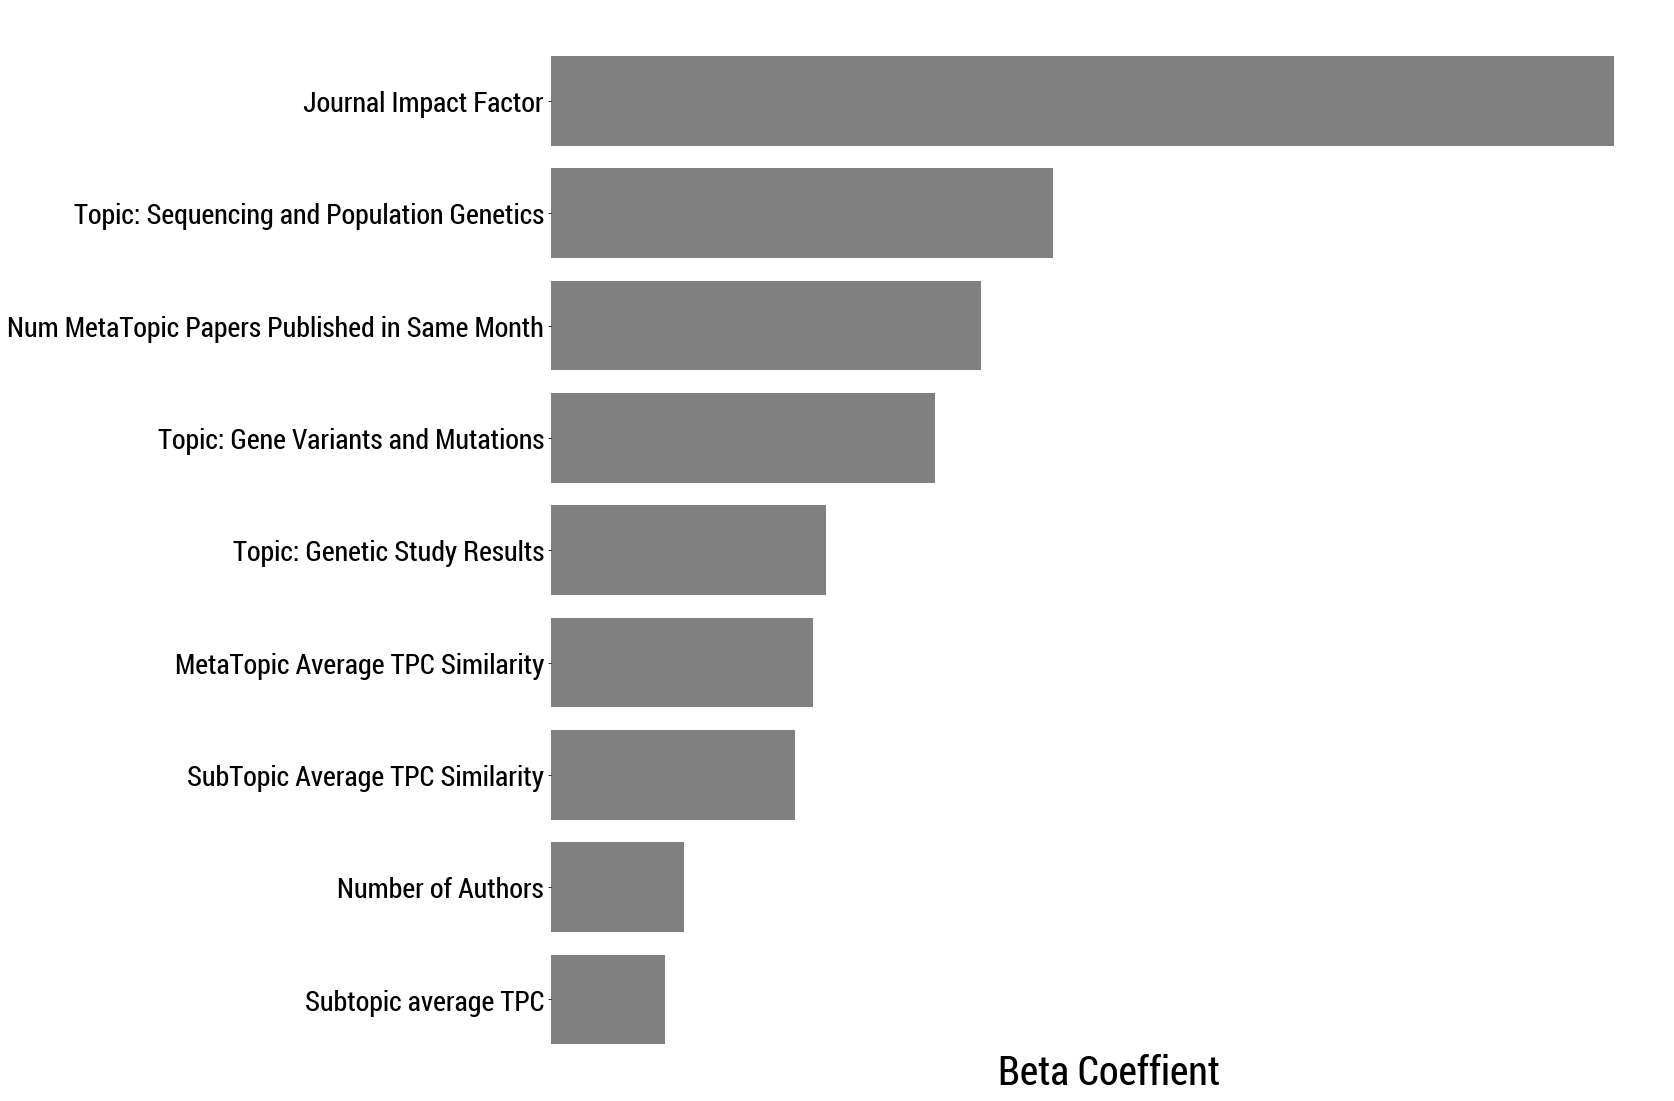

In [55]:
prop = fm.FontProperties(fname = '/Users/kaitlinchaung/Desktop/roboto/RobotoCondensed-Regular.ttf', size=28)
plt.figure(figsize=[20,20])

ind = np.arange(len(topcoeffs.Feature))[::-1]
labels = ['Journal Impact Factor',
          'Topic: Sequencing and Population Genetics',
          'Num MetaTopic Papers Published in Same Month',
          'Topic: Gene Variants and Mutations',
          'Topic: Genetic Study Results',
          'MetaTopic Average TPC Similarity',
          'SubTopic Average TPC Similarity',
          'Number of Authors',
         'Subtopic average TPC']
plt.tight_layout()

plt.barh(topcoeffs.Feature[::-1],topcoeffs.Coef[::-1],color='grey')
plt.xticks([]);
plt.yticks(ind,labels=labels, fontproperties=prop, size=28)
plt.xlabel("Beta Coeffient",fontsize=40,fontproperties=prop, size=40,labelpad=-40)

plt.box(False)
plt.savefig('feature_importance.png',transparent=True,dpi=250, bbox_inches = "tight")

In [13]:
df['predict'] = fit.predict(X_test)
df['resid'] = y_test - df.predict

<Figure size 432x288 with 0 Axes>

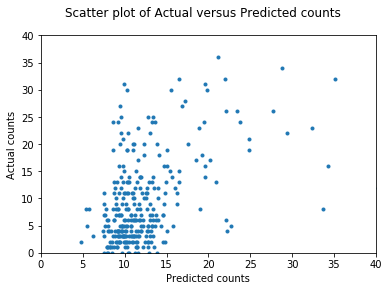

In [19]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.xlim(0,40)
plt.ylim(0,40)
plt.show()

Predicted vs actual.

In [15]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

poisson_predictions = poisson_training_results.get_prediction(X_test)
predictions_summary_frame = poisson_predictions.summary_frame()

predicted_counts=predictions_summary_frame['mean'].reset_index(drop=True)
actual_counts = y_test.reset_index(drop=True)

In [17]:
predicted_counts=predictions_summary_frame['mean'].reset_index(drop=True)
actual_counts = y_test.reset_index(drop=True)

MSE

In [20]:
sqrt(mean_squared_error(actual_counts,predicted_counts))

30.163648052182445

MAE

In [21]:
mae(predicted_counts,actual_counts)

13.44106097738985

R2 Score

In [22]:
r2_score(actual_counts,predicted_counts)

0.22017798872953498